<a href="https://colab.research.google.com/github/lingchm/datascience/blob/master/exercises/socially_distanced_robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID Group Testing

*Convex optimization*, *Ridge regression*

**Problem**

We explore the idea of *group testing* as a strategy for testing a large population for a rare disease by pooling samples together. Suppose that we have a population of $N$ people and we collect saliva samples from each of them. We are booking for genetic signatures of a particular virus in these samples. Let $x_n$ denote the concentration of this material in the sample for the nth person. We will assume that for healthy people $x_n = 0$, but for infected people, $x_n > 0$. Our testing procedure will be to form a series of $M$ mixtures of samples from di erent subsets of people, and then only run tests on these mixtures. The goal here is to set $M < N$, and the question is then whether we can identify the infected people from the results of these tests.

We will consider the following approach: we will form mixtures by constructing random combinations of samples, and we will attempt to recover the original $x$ using a simple convex optimization problem. To mathematically represent the sampling/testing process, assume that we will ultimately run $M$ tests, each of which will tell us the concentration of viral material in the combined sample being tested. For each person, their sample will be divided into $K < M$ equal portions, which will be assigned at random to the $M$ tests. We will do this independently for each of the $N$ people. We can ultimately represent the
concentration of viral material in each of the mixed samples that we will ultimately
test as a vector $y \in \mathbb{R}^M$. We can write $y$ as
$$
y = Ax,
$$
where $A \in \mathbb{R}$ is a matrix that represents the assignment of people to mixed samples/tests. Specifically, A is a matrix where each column is constructed independently
by picking $K$ entries at random, setting them to 1, and setting the remaining entries
to 0. 

Suppose there is no noise in our tests, so that we can estimate $y$ perfectly. Our inference problem is now to estimate $x$ given knowledge of $y$ and $A$. In general, since
$M < N$, recovering $x$ is impossible. However, when $x$ is sparse, meaning that it has
only a few nonzeros (in this case meaning that most of the population is negative), then recovering $x$ is possible, although this fact was only broadly appreciated within the last 15 years or so.

Suppose we are testing a population of size $N=1000$ and we can only process $M=100$ tests. Assume that only $1%$ of the population is positive. Each person's samples is split into $K=10$ batches. 

We want to answer the following questions:
* How we would divide each person's samples?
* What is the best value of K?

**Method**

We formulate the problem as
$$
\min_x ||x||_1 \: \: \: \text{s.t.} Ax=y
$$

This optimization problem can be easily solved using existing packages.

**References**

Credits to Dr. Justin Romberg for designing this problem. 


In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Construct the problem
N = 1000 # Population size
S = 10 # Number of infected individuals
M = 100 # Number of tests
K = 10 # Number of splits of each sample

s: [10977861.2839383   2195572.25678766  1951619.78381125  1351121.38879241
  1254612.71816438   878228.90271506   763677.30670875   627306.35908219]


In [30]:
# Define x0
ind0 = np.random.choice(N,S,0) # index subset 
x0 = np.zeros(N) 
x0[ind0] = np.random.rand(S)

best objective function -0.05418225035205973
best lambda: -9.593285932859318e-08


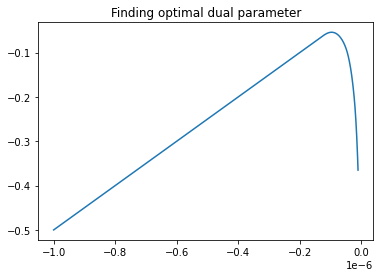

In [31]:
# Define A
A = np.zeros((M,N))
for i in np.arange(N):
    ind = np.random.choice(M,K,0)
    A[ind,i] = 1
y = A @ x0

In [32]:
# Solve the optimization problem
thd = 1e-9
x = cp.Variable(N)
prob = cp.Problem(cp.Minimize(cp.norm1(x)),
                  [A @ x == y, x >= 0])
prob.solve()
print("Number of estimated infected people is", str(np.where(x.value >= thd)[0].shape[0]))

x= [     0.         196422.24482895 303574.25972747      0.
      0.              0.              0.              0.        ]
499996.50455642724


In [33]:
# Experiment with different valueso of K
def experiment(Ks, Ss, n_trials=100):
    res = []
    for i in range(n_trials):
        for S in Ss:
            for K in Ks:
                np.random.seed(i)
                
                # Define x0
                ind0 = np.random.choice(N,S,0) # index subset 
                x0 = np.zeros(N) 
                x0[ind0] = np.random.rand(S)
                
                # Define A
                A = np.zeros((M,N))
                for i in np.arange(N):
                    ind = np.random.choice(M,K,0)
                    A[ind,i] = 1
                y = A @ x0
                
                # Solve the optimization problem
                x = cp.Variable(N)
                prob = cp.Problem(cp.Minimize(cp.norm1(x)),
                                  [A @ x == y, x >= 0])
                prob.solve()
                n = np.where(x.value >= thd)[0].shape[0]
                res.append([S, K, n])
                print("S=", str(S), "K=", str(K), 
                      "Number of estimated infected people is", str(n))
    res = pd.DataFrame(data=np.asarray(res), columns=['S', 'K', 'n infected'])
    return res

Expectation 1075886.5740447226
Std 1151503.889781781


In [ ]:
Ks=[2,3,4,5,6,7,8,9,10]
n_trials=20
res = experiment(Ks, Ss=[10], n_trials)
t = res.groupby('K').sum() / n_trials

In [ ]:
plt.figure()
plt.stem(Ks, t['K'])
plt.title('Probability of error')
plt.xlabel('K')
plt.show()

In [ ]:
Ks=[3,5,10,20,30]
Ss=[10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,40]
n_trials=10
res = experiment(Ks, Ss, n_trials)
print(res[res['S']<25].groupby(['S', 'K']).sum()/n_trials)
t = res.groupby(['S', 'K']).sum()
t['K'] = t['K'] / n_trials
t.groupby(['S']).min()

In [ ]:
# plot the results
plt.figure()
plt.stem(K, t['K'])
plt.title('Probability of error choosing best S')
plt.xlabel('K')
plt.show()

We can take K as low as 4 while still having good chance of perfect reconstruction. When K = 1 or K = 2, the algorithm fails on every trial.